In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import librosa.display
import os

from sklearn.model_selection import train_test_split

In [2]:
path = './CREMA-D/'
audio_path = []
audio_emotion = []

In [3]:
# collects all the audio filename in the variable 'path'
directory_path = os.listdir(path)

In [4]:
for audio in directory_path:
    audio_path.append(path + audio)
    emotion = audio.split('_')
    if emotion[2] == 'SAD':
        audio_emotion.append("sad")
    elif emotion[2] == 'ANG':
        audio_emotion.append("angry")
    elif emotion[2] == 'DIS':
        audio_emotion.append("disgust")
    elif emotion[2] == 'NEU':
        audio_emotion.append("neutral")
    elif emotion[2] == 'HAP':
        audio_emotion.append("happy")
    elif emotion[2] == 'FEA':
        audio_emotion.append("fear")
    else:
        audio_emotion.append("unknown")

In [5]:
emotion_dataset = pd.DataFrame(audio_emotion, columns=['Emotions'])
audio_path_dataset = pd.DataFrame(audio_path, columns=['Path'])
dataset = pd.concat([audio_path_dataset, emotion_dataset], axis= 1)
#print(len(dataset))
print(dataset.head())
# print(dataset['File Path'][55])

                            Path Emotions
0  ./CREMA-D/1001_DFA_ANG_XX.wav    angry
1  ./CREMA-D/1001_DFA_DIS_XX.wav  disgust
2  ./CREMA-D/1001_DFA_FEA_XX.wav     fear
3  ./CREMA-D/1001_DFA_HAP_XX.wav    happy
4  ./CREMA-D/1001_DFA_NEU_XX.wav  neutral


## Visualization

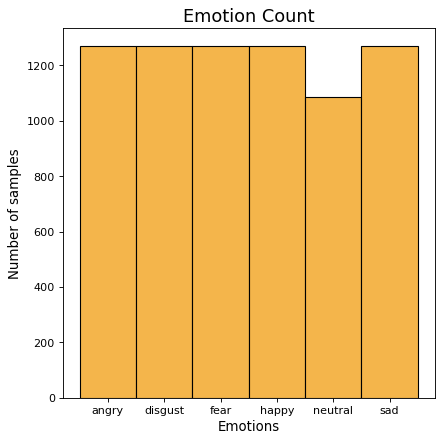

In [6]:
import matplotlib.pyplot as pylab
# counting audio categorized by emotions
fig = plt.figure(figsize=(6,6), dpi=80)
plt.title("Emotion Count", size=16)
plt.xlabel('Emotions', size = 12)
plt.ylabel('Number of samples', size = 12)
sns.histplot(dataset.Emotions, color='#F19C0E')
pylab.savefig('emotions.png')
plt.show()
pylab.close(fig)

## Showing spectrogram and waveplot

In [7]:
emotion_sad = dataset[dataset['Emotions']=='sad']['Path']
print(type(emotion_sad))

<class 'pandas.core.series.Series'>


In [8]:
#choosing a file to plot wave and spectogram
#print(emotion_sad.values[65])
data_path = emotion_sad.values[542]
data, sampling_rate = librosa.load(data_path)


In [9]:
sampling_rate

22050

### Waveplot

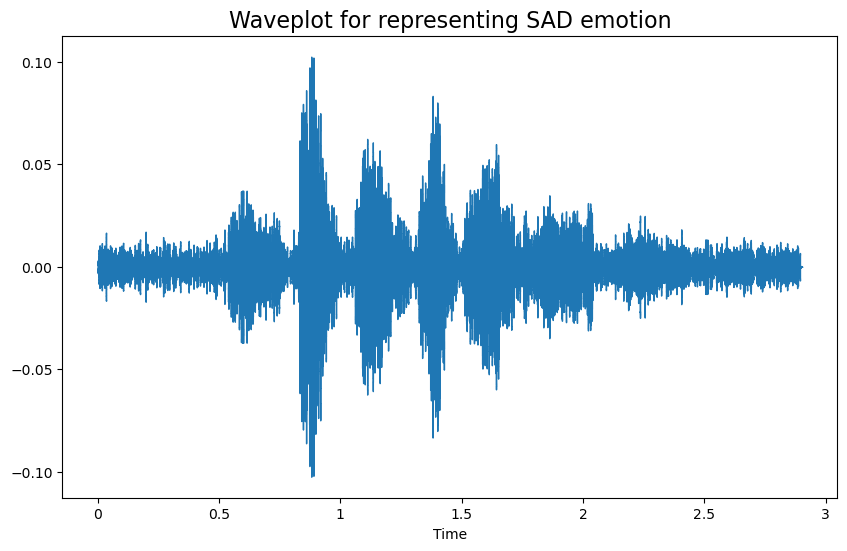

In [10]:
plt.figure(figsize=(10,6))
plt.title("Waveplot for representing SAD emotion", size=16)
librosa.display.waveshow(data, sr=sampling_rate)
pylab.savefig('waveplot_SAD.png')
plt.show()
# pylab.close(fig)

### Spectogram

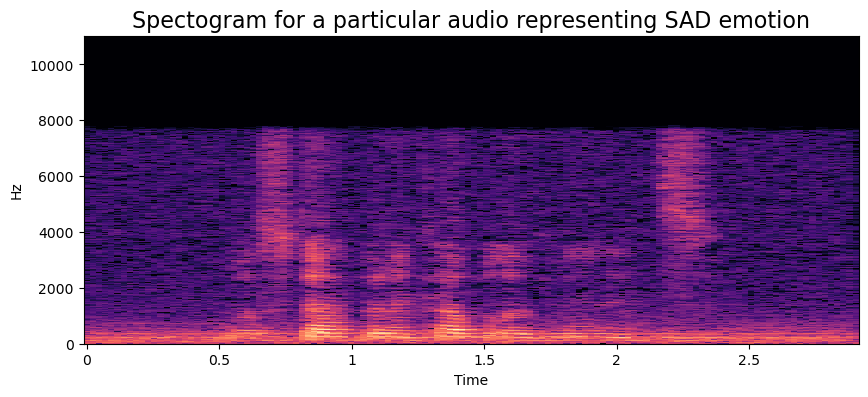

In [11]:
plt.figure(figsize=(10,4))
plt.title("Spectogram for a particular audio representing SAD emotion", size=16)
D = librosa.stft(data)
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
librosa.display.specshow(S_db, sr = sampling_rate, x_axis='time', y_axis='hz')
#plt.show()

## Augmentation (Noise Injection)

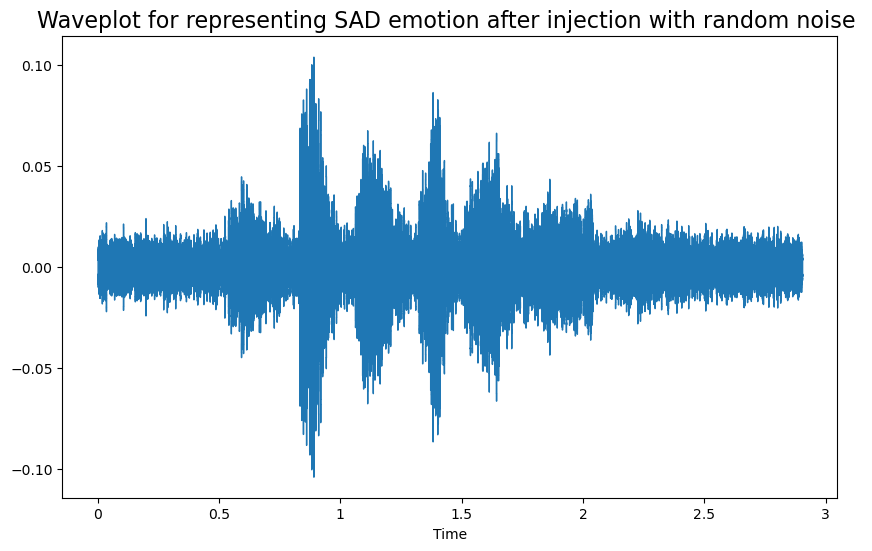

In [12]:
# for audio processing accuracy
# add noise to audio and check how the waveplot changes
# also the observing the change in audio quality

## Augmentation (Noise Injection)
noise_amp = 0.035*np.random.uniform()*np.amax(data)
audio_injected_data = data + noise_amp*np.random.normal(size=data.shape[0])

# waveplot view after noise injection:
plt.figure(figsize=(10,6))
plt.title("Waveplot for representing SAD emotion after injection with random noise ", size=16)
librosa.display.waveshow(audio_injected_data, sr=sampling_rate)
pylab.savefig('waveplot_SAD_with_noise.png')
plt.show()

## Feature extraction

### Creating a DF with extracted Feautures

In [13]:
X, Y = [], []
print("Feature processing...")

for path, emo, index in zip(dataset.Path, dataset.Emotions, range(len(dataset))):
    value, sample = librosa.load(path)
    # noise injection
    noise_amp = 0.035 * np.random.uniform() * np.amax(value)
    value = value + noise_amp * np.random.normal(size=value.shape[0])
    # mfcc
    mfcc = librosa.feature.mfcc(y=value, sr= sample, n_mfcc=13, n_fft=200, hop_length=512)
    mfcc = np.ravel(mfcc.T)
    # mel
    mel = librosa.feature.melspectrogram(y=value, sr=sample, hop_length = 256, n_fft = 512, n_mels=64)
    mel = librosa.power_to_db(mel ** 2)
    mel = np.ravel(mel).T
    result = np.array([])
    result = np.hstack((result, mfcc, mel))
    #print(result)
    result = np.array(result)
    X.append(result)
    Y.append(emo)

Feature processing...


In [14]:
# print(X)
# print(Y)
extracted_audio_df = pd.DataFrame(X)
extracted_audio_df["emotion_of_audio"] = Y
print(extracted_audio_df.shape)
print(extracted_audio_df.tail(10))
extracted_audio_df = extracted_audio_df.fillna(0)
#print(extracted_audio_df.isna().any())

(7442, 30457)
               0          1          2          3          4          5  \
7432 -767.482297  -6.831062  -1.651257  20.350856  -2.598576  13.235024   
7433 -695.197279 -57.683892  -5.845754  29.423464  29.303364 -22.359425   
7434 -756.714662 -30.995002  -7.683401  27.695336  -2.732182  -6.751852   
7435 -813.588945  -6.191886 -27.908322  19.047015  12.956009   5.634553   
7436 -657.328189 -70.830418 -14.259305  -2.233260  13.878840   2.743213   
7437 -755.002892 -50.084115  -1.255107  14.969351   5.457614   1.290036   
7438 -749.147551 -23.105073  -5.056966  21.435763   2.665729   3.623923   
7439 -737.948508 -49.295719 -10.292055  21.788331  32.356946 -10.846362   
7440 -817.646105  27.838921   3.908495  14.764029   4.622514  -5.706378   
7441 -741.735624 -67.850727  -8.565580   9.328752   9.595991  11.993794   

              6          7          8          9  ...  30447  30448  30449  \
7432  -9.172291 -20.187478   0.271932   0.960365  ...    NaN    NaN    NaN   
7433

## Data splitting and transformation

In [15]:
# preparing to train
X = extracted_audio_df.drop(labels='emotion_of_audio', axis= 1)
Y = extracted_audio_df['emotion_of_audio']

x_train, x_test, y_train, y_test = train_test_split(np.array(X), Y, test_size=0.2)

In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score


scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

## Model creation, training and fitting

In [17]:
%%time
mlp_model = MLPClassifier(activation='logistic', 
                         solver='sgd',
                         hidden_layer_sizes=100,
                         alpha=0.839903176695813,
                         batch_size=150,
                         learning_rate='adaptive',
                         max_iter=100000) # logistic instead of relu
# Fit mlp model
mlp_model.fit(x_train,y_train)

CPU times: total: 4h 48min 56s
Wall time: 48min 15s


MLPClassifier(activation='logistic', alpha=0.839903176695813, batch_size=150,
              hidden_layer_sizes=100, learning_rate='adaptive', max_iter=100000,
              solver='sgd')

## Accuracy calculation

In [18]:
y_pred = mlp_model.predict(x_test)
accuracy=accuracy_score(y_true=y_test, y_pred=y_pred)

# the accuracy didn't turn out to be that good :(
print("\nModel:{}    Accuracy: {:.2f}%".
          format(type(mlp_model).__name__ , accuracy*100))


Model:MLPClassifier    Accuracy: 38.15%


## Prediction verification

In [19]:
# the prediction made by the model:
print("The Prediction Made By Model: ")
print("<<<===========================================>>>")
df = pd.DataFrame({'Actual': y_test, 'Predict': y_pred})
print(df.head())

The Prediction Made By Model: 
<<<===========================================>>>
       Actual  Predict
6147    happy    happy
901      fear    happy
3443  neutral    happy
1829  neutral  neutral
5859  neutral  disgust


In [20]:
print(len(df))

1489


In [21]:
print(df[:][10:50])

       Actual  Predict
909       sad     fear
4911  disgust  disgust
2604      sad      sad
1778      sad  neutral
3281      sad      sad
6935    happy      sad
557      fear  disgust
5185  neutral  neutral
4545     fear     fear
173   disgust    happy
7218    angry    angry
5722  disgust      sad
3468    happy     fear
681   neutral  disgust
2588  disgust      sad
5293    angry    happy
1682    happy      sad
6588     fear     fear
1458  disgust  disgust
2727    angry    angry
836   disgust      sad
2583     fear      sad
3294      sad      sad
2633    angry    angry
1452  disgust  disgust
4231  neutral  disgust
6168    happy    happy
4420  disgust    happy
5130  disgust  disgust
6363      sad  neutral
4690  disgust      sad
2664  disgust     fear
7011    happy    happy
5957     fear  neutral
656     angry    happy
1291  neutral    angry
7132  neutral      sad
1392  disgust  disgust
4605  neutral      sad
4403    angry     fear
